## Workers Function
---

In [1]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Full Version 1.1

In [2]:
# ----------------------------------------- Crowdsourcing task optimization ----------------------------------------- 

# ### Tasks and Workers Dataframe Construction
def workers_algorithm(total_tasks = 100, total_workers = 40, p_hard_tasks = 0.2, p_good_workers = 0.8,
                      answers_key = ["liver", "blood", "lung", "brain", "heart"], 
                      p_train_tasks = 0.4, workers_per_task = 7):
    total_tasks =  total_tasks #int(input("Number of Total Tasks: "))  #100
    total_workers = total_workers #int(input("Number of Total Workers: "))  #40

    p_hard_tasks = float(p_hard_tasks) #float(input("Percentage of Hard Tasks (decimal): ")) # 0.2
    n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))
    p_easy_tasks = 1-p_hard_tasks 
    n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))
    print('Hard Tasks: {} \nEasy Tasks: {}'.format(n_hard_tasks, n_easy_tasks))

    #Workers variables
    p_good_workers = float(p_good_workers) #float(input("Percentage of Good Workers (decimal): ")) #0.8
    n_good_workers = int(round(p_good_workers*total_workers,0))
    p_poor_workers = 1-p_good_workers
    n_poor_workers = int(round(p_poor_workers*total_workers,0))
    print('Good Workers: {} \nPoor Workers: {}'.format(n_good_workers, n_poor_workers))

    # Workers simulation
    workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]
    poor_workers = [worker for worker in np.random.choice(workers, n_poor_workers, replace=False)]
    good_workers = [worker for worker in set(workers)-set(poor_workers)]

    # Creating the workers dataframe
    df_workers = pd.DataFrame()
    df_workers['worker_id'] = workers

    label_worker = []
    for i in range(total_workers):
        if workers[i] in good_workers:
            label_worker.append('good_worker')
        else:
            label_worker.append('poor_worker')

    df_workers['label_worker'] = label_worker

    # Tasks simulatiom
    tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
    easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
    hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

    answers_key = ["liver", "blood", "lung", "brain", "heart"]
    #print('Tasks Answers: {}'.format(answers_key))
    real_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]
    df_tasks = pd.DataFrame()
    df_tasks['task_id'] = tasks
    df_tasks['real_answers'] = real_answers

    label_task = []
    for i in range(total_tasks):
        if tasks[i] in hard_tasks:
            label_task.append('hard_task')
        else:
            label_task.append('easy_task')

    df_tasks['label_task'] = label_task


    # ----------------------------------------- Probability to Respond ----------------------------------------- 
    cut_tasks = 0.75
    cut_workers = 0.75

    probs_tasks = []
    for i in label_task:
        if i == 'easy_task':
            probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'hard_task':
            probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
        else: probs_tasks.append(1)

    probs_tasks = [item for prob in probs_tasks for item in prob]

    probs_workers = []
    for i in label_worker:
        if i == 'good_worker':
            probs_workers.append(np.random.choice((np.arange(cut_workers, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'poor_worker':
            probs_workers.append(np.random.choice((np.arange(0.5, cut_workers, 0.01)), 1)) #a random number form chance to 1
        else: probs_workers.append(1)

    probs_workers = [item for prob in probs_workers for item in prob]

    df_workers['prob_worker'] = probs_workers
    df_tasks['prob_task'] = probs_tasks


    # ----------------------------------------- Stage 1 ----------------------------------------- 

    p_train_tasks = float(p_train_tasks) #float(input("Percentage of Tasks to Train (decimal): ")) #.4 #percentage
    #workers_per_task = 7 #more conditions

    tasks_to_train = int(p_train_tasks*total_tasks)
    print('Tasks to train: {}'.format(tasks_to_train))

    # Take randomly the number of tasks to train the workers
    training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)

    list_tasks1 = [[training_tasks[i]]*workers_per_task for i in range(tasks_to_train)] #replicate the tasks to train 
    list_tasks1 = [item for sublist in list_tasks1 for item in sublist] #flat and clean list

    # Asign workers on every task (we're assuming the tasks are ordered)
    tasks_workers1 = [np.random.choice(workers, workers_per_task, replace=False) for task in training_tasks]
    tasks_workers1 = [worker for sublist in tasks_workers1 for worker in sublist] #flat and clean list

    temp_frame = pd.DataFrame()
    temp_frame['task_id'] = list_tasks1
    temp_frame['worker_id'] = tasks_workers1

    workers_agg = temp_frame.groupby('worker_id').agg('count')
    workers_agg.sort_values('task_id', ascending=False)
    num_workers_trained = len(workers_agg.reset_index())
    print('Workers Trained: {}'.format(num_workers_trained))

    # Merge the datasets stage 1
    temp_frame1 = pd.merge(temp_frame, df_tasks, on='task_id', how='left')
    df_tw1 = pd.merge(temp_frame1, df_workers, on='worker_id', how='left')

    #Probability to asnwer correct
    df_tw1['prob_answer'] = 1-(df_tw1['prob_worker']*(1-df_tw1['prob_task']))

    # We want to get where is the position of the real_answer column on the answer_key array
    positions = []
    for answer in df_tw1['real_answers']:
        for k in range(len(answers_key)):
            if answers_key[k] == answer:
                positions.append(k)

    # Assign a vector of probabilities depending on the position of the item on anser_key array
    list_vect_probs = []
    for p in df_tw1['prob_answer']:
        for i in positions:
            vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
            vec_probs.insert(i,p) #insert place, value
        list_vect_probs.append(vec_probs)

    #"Predict" every answer
    worker_answers = []
    for vec in list_vect_probs:
        worker_answers.append(np.random.choice(answers_key, 1, p=vec))

    worker_answers = [item for answer in worker_answers for item in answer]
    df_tw1['worker_answers'] = worker_answers

    #We match the real answers with worker answers
    vec_matches = df_tw1['worker_answers'] == df_tw1['real_answers']
    predict_value =[1 if i == True else 0 for i in vec_matches]
    df_tw1['performance'] = predict_value

    # ----------------------------------------- Measuring Performance ----------------------------------------- 

    cutoff_task = 0.5 #More than 50% of consensus

    tasks_mean1 = df_tw1.groupby('task_id').mean().sort_values('performance', ascending=False)
    first_tasks = tasks_mean1[tasks_mean1['performance'] >= cutoff_task]['performance']

    # - Trained Workers
    workers_mean1 = df_tw1.groupby('worker_id').mean().sort_values('performance', ascending=False)
    df_workers = pd.merge(workers_mean1.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

    # - prob_task: Average of difficulty of the tasks asigned to the workers, this measure should be close each other in order to make the metrics equivalent
    # - prob_worker: Prob to score correct
    # - prob_answer: Combined probability of score and task difficulty
    # - performance: Percentage of the times the worker score correct

    #print('Workers Performance Summary: \n{}'.format(df_workers.describe()))

    cutoff1 = df_workers['performance'].quantile(.3)
    cutoff2 = df_workers['prob_worker'].quantile(.5)
    print('Cutoff for Performance: {} \nCutoff for Probability: {}'.format(
        round(cutoff1, 3), round(cutoff2, 3)))

    # ----------------------------------------- Stage 2 - Best workers ----------------------------------------- 

    # We are going take only the best workers, it means high probability and high performance, above certain percentile. 
    list_perf = [1 if i > cutoff1 else 0 for i in df_workers['performance']]
    list_prob = [1 if i > cutoff2 else 0 for i in df_workers['prob_worker']]

    flag_best_workers = []
    for i in range(len(list_perf)):
        if list_perf[i] == 1 and list_prob[i] ==1 : #we need to be strict here
            flag_best_workers.append(1)
        else: flag_best_workers.append(0)

    print('Selected Best Workers: {}'.format(sum(flag_best_workers)))

    df_workers['best_worker'] = flag_best_workers
    df_workers2 = df_workers[df_workers['best_worker']==1]
    # But we want to "reset" them:
    df_workers2 = df_workers2[['worker_id','prob_worker','label_worker']]
    best_workers = [i for i in df_workers2['worker_id']]

    # - Now we take the tasks that we decide were already difficult
    # - Then we're going to add them in the df_tasks that we did not use
    # - This "rest" of the tasks remain are going to be performed for our final workers
    tasks_mean1 = tasks_mean1.reset_index()
    list_done_tasks = [1 if i > cutoff_task else 0 for i in tasks_mean1['performance']]
    tasks_mean1['done_task'] = list_done_tasks
    #All those with value 1 is because was good consensus, so we don't need them to evaluate again
    tasks_mean1[tasks_mean1['done_task']==1]
    done_tasks = tasks_mean1[tasks_mean1['done_task']==1]['task_id']
    done_tasks = [i for i in done_tasks]
    # - Those trained_task with value 1 don't select them
    # - The best workers will do the rest of the job
    # - Then we measure the accuracy of the over tasks and workers
    # - Simulations and ploting the acuracy and the best workers, 
    # - Ploting workers converge on truth answer
    print('Tasks already done {} from the total of {}'.format(len(done_tasks), len(df_tasks)))
    # Take all the rest of the tasks excluding those that already we have concensus
    # This is the number we want to evaluate in stage 2
    df_tasks2 = df_tasks[~df_tasks['task_id'].isin(done_tasks)]
    #print('Tasks to be done: {}'.format(len(df_tasks2)))

    # ----------------------------------------- Stage 2 - Task Assignation ----------------------------------------- 
    # Before we assigne the best workers to the rest of the tasks we have to be sure that the workers dont responde the same task
    # All the tasks done for the best workers and is not in the list of tasks already done
    tasks_redo = df_tw1[~df_tw1['task_id'].isin(done_tasks)]
    tasks_redo = tasks_redo.reset_index()
    tasks_redo_unique = tasks_redo['task_id'].unique()
    tasks_redo_unique =  [i for i in tasks_redo_unique]

    # ** Check Groups: ** All the trained and consensus tasks + All the tasks already done = Trained Tasks
    #print(' Done Taks: {} \n Tasks to redo: {} \n Original Tasks to train: {}  \n Value: {}'.format(
    #    len(done_tasks), len(tasks_redo_unique), tasks_to_train, len(done_tasks)+len(tasks_redo_unique)==tasks_to_train))

    tasks_workers2 = [] #we should take in account that there is a low chance that the worker repat the task
    for i in tasks_redo_unique:
        each = [i for i in tasks_redo[tasks_redo['task_id']==str(i)]['worker_id']] # show the worker id of every task
        rest_workers = [worker for worker in set(best_workers)-set(each)] # select all those not did the task before
        if len(rest_workers) > workers_per_task:
            tasks_workers2.append(np.random.choice(rest_workers, workers_per_task, replace=False))
        else:
            tasks_workers2.append(np.random.choice(rest_workers, workers_per_task))

    tasks_workers2 = [worker for sublist in tasks_workers2 for worker in sublist] #flat and clean list

    list_tasks2 = [[tasks_redo_unique[i]]*workers_per_task for i in range(len(tasks_redo_unique))] #replicate the tasks to train 
    list_tasks2 = [item for sublist in list_tasks2 for item in sublist] #flat and clean list

    temp_frame1 = pd.DataFrame()
    temp_frame1['task_id'] = list_tasks2
    temp_frame1['worker_id'] = tasks_workers2
    # - **Tasks Un-done**
    tasks_undone_unique = df_tasks[~df_tasks['task_id'].isin(training_tasks)]['task_id']
    tasks_undone_unique = [i for i in tasks_undone_unique]
    # ** Check Groups: ** Tasks re-do unique + Tasks un-done unique = df_tasks2 
    #print('Final Stage\n Tasks Re-do: {} \n Tasks Not Done: {}'.format(
    #    len(tasks_redo_unique) , len(tasks_undone_unique)))

    tasks_workers3 = []
    for i in tasks_undone_unique:
        tasks_workers3.append(np.random.choice(best_workers, workers_per_task, replace=False))

    tasks_workers3 = [worker for sublist in tasks_workers3 for worker in sublist] #flat and clean list

    list_tasks3 = [[tasks_undone_unique[i]]*workers_per_task for i in range(len(tasks_undone_unique))] #replicate the tasks to train 
    list_tasks3 = [item for sublist in list_tasks3 for item in sublist] #flat and clean list

    temp_frame2 = pd.DataFrame()
    temp_frame2['task_id'] = list_tasks3
    temp_frame2['worker_id'] = tasks_workers3

    # ----------------------------------------- Final Join ----------------------------------------- 

    temp_frame = temp_frame1.append(temp_frame2, ignore_index=True)
    #print('Number of Tasks in Final Join: {}'.format(len(temp_frame['task_id'].unique())))

    temp_frame0 = pd.merge(temp_frame, df_tasks2, on='task_id', how='left')
    df_tw = pd.merge(temp_frame0, df_workers2, on='worker_id', how='left')

    #Probability to asnwer correct
    df_tw['prob_answer'] = 1-(df_tw['prob_worker']*(1-df_tw['prob_task']))

    # We want to get where is the position of the real_answer column on the answer_key array
    positions = []
    for answer in df_tw['real_answers']:
        for k in range(len(answers_key)):
            if answers_key[k] == answer:
                positions.append(k)

    # Assign a vector of probabilities depending on the position of the item on anser_key array
    list_vect_probs = []
    for p in df_tw['prob_answer']:
        for i in positions:
            vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
            vec_probs.insert(i,p) #insert place, value
        list_vect_probs.append(vec_probs)

    #"Predict" every answer
    worker_answers = []
    for vec in list_vect_probs:
        worker_answers.append(np.random.choice(answers_key, 1, p=vec))

    worker_answers = [item for answer in worker_answers for item in answer]
    df_tw['worker_answers'] = worker_answers
    #We match the real answers with worker answers
    vec_matches = df_tw['worker_answers'] == df_tw['real_answers']
    predict_value =[1 if i == True else 0 for i in vec_matches]
    df_tw['performance'] = predict_value

    # ----------------------------------------- Accuracy ----------------------------------------- 

    tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)
    final_tasks = tasks_mean[tasks_mean['performance'] >= cutoff_task]['performance']

    #print('\n \n ==== Agreement on the Tasks ==== \n \n')

    #print(first_tasks.append(final_tasks).sort_values(ascending=False))

    print('Task consensus: {} of {}'.format(len(final_tasks) + len(done_tasks), len(df_tasks)))

    accu = (len(first_tasks) + len(final_tasks)) / len(df_tasks)

    print('Accuracy Simulation: {} \n============================'.format(accu))
    
    return accu

## Predefined Parameters
---

In [3]:
workers_algorithm()

Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 


0.33

In [4]:
accu_1 = workers_algorithm(total_tasks = 100, total_workers = 40, p_hard_tasks = 0.2, p_good_workers = 0.8,
                           answers_key = ["liver", "blood", "lung", "brain", "heart"], 
                           p_train_tasks = 0.4, workers_per_task = 7)

Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.286 
Cutoff for Probability: 0.865
Selected Best Workers: 13
Tasks already done 14 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 


In [5]:
accu_1

0.3

### Change Number of Workers, Fixed all the rest variables

In [6]:
workers_algorithm(30)

Hard Tasks: 6 
Easy Tasks: 24
Good Workers: 32 
Poor Workers: 8
Tasks to train: 12
Workers Trained: 36
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 4 from the total of 30
Task consensus: 9 of 30
Accuracy Simulation: 0.3 


0.3

- Create a function that use the algorithmn with different number of workers
- Evaluate in the range of all the workers

In [7]:
def workers_parameter(max_workers = 100):
    results = []
    for i in np.arange(1, max_workers, 1):
        try:
            results.append((i,workers_algorithm(total_workers = i+1)))
        except Exception:
            pass
    return results

In [8]:
results = workers_parameter(100)

Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 1
Tasks to train: 40
Workers Trained: 7
Cutoff for Performance: 0.15 
Cutoff for Probability: 0.87
Selected Best Workers: 1
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 8
Cutoff for Performance: 0.152 
Cutoff for Probability: 0.85
Selected Best Workers: 2
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.095 
Cutoff for Probability: 0.835
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 37
Cutoff for Performance: 0.082 
Cutoff for Probability: 0.83
Selected Best Workers: 12
Tasks already done 6 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 38
Cutoff for Performance: 0.092 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 6 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Worke

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 63
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 64
Cutoff for Performance: 0.333 
Cutoff for Probability: 0.82
Selected Best Workers: 15
Tasks already done 17 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 52 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Work

Task consensus: 42 of 100
Accuracy Simulation: 0.42 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 31
Tasks already done 13 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 88
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 21
Tasks already done 10 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.805
Selected Best Workers: 24
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Wor

In [9]:
#results

- Create a function that repeat the results vector of the workers variation
- It has to register the time 
- Create a clean dataset with all the simulations

In [15]:
def get_accuracy_df(number_simulations = 10, max_workers = 50):
    startTime= dt.now()
    simulations = []
    for j in range(number_simulations):
        results = workers_parameter(max_workers)
        simulations.append((j, results))

    df_simulations = pd.DataFrame()
    vec_workers, vec_accuracy, vec_simulation = [], [], []
    for i in sims:
        for j in i[1]:
            vec_workers.append(j[0])
            vec_accuracy.append(j[1])
            vec_simulation.append(i[0])

    df_simulations['workers'] = vec_workers
    df_simulations['accuracy'] = vec_accuracy
    df_simulations['simulation'] = vec_simulation

    timeElapsed = dt.now()-startTime
    print('Process (hh:mm:ss.ms) {}'.format(timeElapsed))
    
    return df_simulations, timeElapsed

In [16]:
#TRY THIS NEW FUNCTION

In [17]:
df_simulations, timeElapsed = get_accuracy_df(50, 100)

Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 1
Tasks to train: 40
Workers Trained: 7
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.88
Selected Best Workers: 0
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 8
Cutoff for Performance: 0.198 
Cutoff for Probability: 0.875
Selected Best Workers: 3
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.148 
Cutoff for Probability: 0.875
Selected Best Workers: 11
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 37
Cutoff for Performance: 0.193 
Cutoff for Probability: 0.82
Selected Best Workers: 13
Tasks already done 10 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 38
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.845
Selected Best Workers: 15
Tasks already done 8 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Wo

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 17
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 21
Tasks already done 12 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 22
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 52 
Poor Workers: 13
Tasks to train: 40
Work

Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 24
Tasks already done 10 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 23
Tasks already done 11 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 18
Tasks to train: 40
Work

Cutoff for Performance: 0.083 
Cutoff for Probability: 0.825
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.135 
Cutoff for Probability: 0.81
Selected Best Workers: 8
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 21 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 26
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.82
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 27
Cutoff for Performance: 0.091 
Cutoff for Probability: 0.84
Selected Best Workers: 7
Tasks already done 6 from the total of 100
Task consensus: 

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 52
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 19
Tasks already done 7 from the total of 100
Task consensus: 16 of 100
Accuracy Simulation: 0.16 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 53
Cutoff for Performance: 0.157 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 43 
Poor Workers: 11
Tasks to train: 40
Wo

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 77
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 24
Tasks already done 11 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 74
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 25
Tasks already done 10 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 64 
Poor Workers: 16
Tasks to train: 40
Worke

Cutoff for Performance: 0.247 
Cutoff for Probability: 0.89
Selected Best Workers: 1
Tasks already done 11 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.205 
Cutoff for Probability: 0.86
Selected Best Workers: 2
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.21 
Cutoff for Probability: 0.885
Selected Best Workers: 4
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.185 
Cutoff for Probability: 0.78
Selected Best Workers: 2
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.162 
Cutoff for Probability: 0.87
Selected Best

Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.095 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.835
Selected Best Workers: 12
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 15
Tasks already done 5 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.155 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 9 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 24
Tasks already done 10 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Wor

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 23
Tasks already done 9 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 19
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 27
Cutoff for Performance: 0.273 
Cutoff for Probability: 0.87
Selected Best Workers: 7
Tasks already done 14 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 28
Cutoff for Performance: 0.154 
Cutoff for Probability: 0.88
Selected Best Workers: 9
Tasks already done 8 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.8
Selected Best Workers: 8
Tasks already done 6 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers 

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 43 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 53
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.84
Selected Best Workers: 17
Tasks already done 13 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 54
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.835
Selected Best Workers: 17
Tasks already done 12 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.155 
Cutoff for Probability: 0.82
Selected Best Workers: 22
Tasks already done 11 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
W

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 64 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 78
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 23
Tasks already done 11 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 65 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 78
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 25
Tasks already done 12 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Worke

Cutoff for Performance: 0.184 
Cutoff for Probability: 0.825
Selected Best Workers: 4
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 13
Cutoff for Performance: 0.166 
Cutoff for Probability: 0.85
Selected Best Workers: 4
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 11 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 14
Cutoff for Performance: 0.188 
Cutoff for Probability: 0.83
Selected Best Workers: 5
Tasks already done 11 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 12 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 15
Cutoff for Performance: 0.155 
Cutoff for Probability: 0.79
Selected Best Workers: 3
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 13 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 16
Cutoff for Performance: 0.086 
Cutoff for Probability: 0.81
Selected B

Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 42
Cutoff for Performance: 0.115 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 43
Cutoff for Performance: 0.187 
Cutoff for Probability: 0.81
Selected Best Workers: 14
Tasks already done 10 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 6 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.109 
Cutoff for Probability: 0.83
Selected Best Workers: 22
Tasks already done 12 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.84
Selected Best Workers: 25
Tasks already done 10 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
W

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 4 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Workers

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.074 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.22 
Cutoff for Probability: 0.825
Selected Best Workers: 11
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 31
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.83
Selected Best Workers: 9
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Worke

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.173 
Cutoff for Probability: 0.85
Selected Best Workers: 21
Tasks already done 11 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Wor

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 5 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 78
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 24
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers 

Cutoff for Performance: 0.193 
Cutoff for Probability: 0.89
Selected Best Workers: 5
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.185 
Cutoff for Probability: 0.85
Selected Best Workers: 4
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.159 
Cutoff for Probability: 0.855
Selected Best Workers: 4
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 15 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 19
Cutoff for Performance: 0.161 
Cutoff for Probability: 0.82
Selected Best Workers: 5
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.246 
Cutoff for Probability: 0.815
Selected 

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.109 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 7 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers 

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 12
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 74
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 96
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 9
Tasks already done 4 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 95
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 28
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.85
Selected Best Workers: 10
Tasks already done 13 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.82
Selected Best Workers: 10
Tasks already done 7 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 12
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers 

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.83
Selected Best Workers: 18
Tasks already done 11 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 9
Tasks already done 4 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Worke

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 23
Tasks already done 11 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 28
Tasks already done 8 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers

Cutoff for Performance: 0.153 
Cutoff for Probability: 0.84
Selected Best Workers: 5
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.119 
Cutoff for Probability: 0.81
Selected Best Workers: 7
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.154 
Cutoff for Probability: 0.825
Selected Best Workers: 8
Tasks already done 9 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.098 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 


Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.81
Selected Best Workers: 19
Tasks already done 11 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
Work

Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.86
Selected Best Workers: 20
Tasks already done 11 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 15
Tasks already done 4 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Work

Cutoff for Performance: 0.141 
Cutoff for Probability: 0.77
Selected Best Workers: 3
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.174 
Cutoff for Probability: 0.9
Selected Best Workers: 3
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.29 
Cutoff for Probability: 0.83
Selected Best Workers: 4
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.107 
Cutoff for Probability: 0.79
Selected Best Workers: 4
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.15 
Cutoff for Probability: 0.815
Selected Best Wor

Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.172 
Cutoff for Probability: 0.86
Selected Best Workers: 15
Tasks already done 12 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.182 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 11 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Work

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 6 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Worke

Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 9 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.815
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 26
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Worker

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 28
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.84
Selected Best Workers: 7
Tasks already done 9 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.142 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.151 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 9 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.79
Selected Best Workers: 20
Tasks already done 6 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 6 from the total of 100
Task consensus: 13 of 100
Accuracy Simulation: 0.13 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Workers

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 79
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 20
Tasks already done 9 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 26
Tasks already done 10 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 12 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Worke

Cutoff for Performance: 0.175 
Cutoff for Probability: 0.785
Selected Best Workers: 7
Tasks already done 9 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 12 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 15
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.9
Selected Best Workers: 3
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 13 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 16
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.81
Selected Best Workers: 5
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.162 
Cutoff for Probability: 0.83
Selected Best Workers: 5
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performanc

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 43
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 12 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 44
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 6 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Tr

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 69
Cutoff for Performance: 0.18 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 13 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 57 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 7 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Worker

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 22
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 6 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 94
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers T

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 32
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.865
Selected Best Workers: 11
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 33
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.83
Selected Best Workers: 9
Tasks already done 7 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.075 
Cutoff for Probability: 0.825
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Worke

Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.152 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 11 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.85
Selected Best Workers: 21
Tasks already done 12 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Wor

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 13
Tasks already done 4 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 23
Tasks already done 8 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 26
Tasks already done 11 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.176 
Cutoff for Probability: 0.835
Selected Best Workers: 7
Tasks already done 11 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 21
Cutoff for Performance: 0.214 
Cutoff for Probability: 0.83
Selected Best Workers: 10
Tasks already done 10 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 22
Cutoff for Performance: 0.219 
Cutoff for Probability: 0.82
Selected Best Workers: 8
Tasks already done 10 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Work

Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.81
Selected Best Workers: 17
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.84
Selected Best Workers: 15
Tasks already done 11 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Wor

Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.845
Selected Best Workers: 25
Tasks already done 15 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 74
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 7 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 18
Tasks already done 5 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Wor

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 95
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 24
Tasks already done 6 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 1
Tasks to train: 40
Workers Trained: 7
Cutoff for Performance: 0.225 
Cutoff for Probability: 0.83
Selected Best Workers: 2
Tasks already done 9 from the total of 100
Hard Tasks: 20 
E

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.145 
Cutoff for Probability: 0.8
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.202 
Cutoff for Probability: 0.855
Selected Best Workers: 12
Tasks already done 12 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 37
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 10
Tasks already done 6 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Worker

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.18 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 12 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 63
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Work

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 87
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 15
Tasks already done 7 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers

Cutoff for Performance: 0.178 
Cutoff for Probability: 0.825
Selected Best Workers: 6
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.89
Selected Best Workers: 7
Tasks already done 11 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.165 
Cutoff for Probability: 0.815
Selected Best Workers: 9
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.85
Selected Best Workers: 8
Tasks already done 13 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.044 
Cutoff for Probability: 0.85
Selected Best Workers: 17
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.83
Selected Best Workers: 15
Tasks already done 11 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
Work

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 19
Tasks already done 6 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 20
Tasks already done 9 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 12
Tasks already done 5 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Worke

Cutoff for Performance: 0.224 
Cutoff for Probability: 0.805
Selected Best Workers: 2
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.227 
Cutoff for Probability: 0.85
Selected Best Workers: 3
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.225 
Cutoff for Probability: 0.825
Selected Best Workers: 2
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.192 
Cutoff for Probability: 0.82
Selected Best Workers: 3
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.121 
Cutoff for Probability: 0.855
Selected B

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 12
Tasks already done 3 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.89
Selected Best Workers: 14
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers 

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.855
Selected Best Workers: 21
Tasks already done 14 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 10
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.84
Selected Best Workers: 23
Tasks already done 11 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Work

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 17
Tasks already done 10 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 19
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Work

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 28
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 3 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.124 
Cutoff for Probability: 0.84
Selected Best Workers: 8
Tasks already done 8 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.8
Selected Best Workers: 11
Tasks already done 7 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Tr

Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.81
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 22
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 12 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Worker

Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 81
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 20
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 79
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 22
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers

Cutoff for Performance: 0.29 
Cutoff for Probability: 0.845
Selected Best Workers: 3
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 12 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 15
Cutoff for Performance: 0.112 
Cutoff for Probability: 0.81
Selected Best Workers: 4
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 13 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 16
Cutoff for Performance: 0.172 
Cutoff for Probability: 0.83
Selected Best Workers: 5
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.188 
Cutoff for Probability: 0.81
Selected Best Workers: 5
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.178 
Cutoff for Probability: 0.785
Selected 

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 44
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 8 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.84
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 5
Tasks already done 2 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.167 
Cutoff for

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 57 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 70
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 24
Tasks already done 10 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Worker

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 96
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 22
Tasks already done 13 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tas

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 33
Cutoff for Performance: 0.091 
Cutoff for Probability: 0.87
Selected Best Workers: 11
Tasks already done 4 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.805
Selected Best Workers: 11
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 9 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Worke

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 14
Tasks already done 4 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 14
Tasks already done 7 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.835
Selected Best Workers: 19
Tasks already done 12 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Worker

Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 7 from the total of 100
Task consensus: 14 of 100
Accuracy Simulation: 0.14 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers

Cutoff for Performance: 0.182 
Cutoff for Probability: 0.815
Selected Best Workers: 8
Tasks already done 9 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 21
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.85
Selected Best Workers: 6
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 22
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.835
Selected Best Workers: 9
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.8
Selected Best Workers: 6
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks 

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 15
Tasks already done 6 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.84
Selected Best Workers: 12
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Wor

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 22
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers 

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 1
Tasks to train: 40
Workers Trained: 7
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.96
Selected Best Workers: 3
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 8
Cutoff for Performance: 0.144 
Cutoff for Probability: 0.82
Selected Best Workers: 3
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.095 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 37
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.82
Selected Best Workers: 12
Tasks already done 12 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 38
Cutoff for Performance: 0.127 
Cutoff for Probability: 0.85
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Worker

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.815
Selected Best Workers: 13
Tasks already done 3 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 64
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 10 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 52 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 63
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Worker

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 21
Tasks already done 10 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 12
Tasks already done 4 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Worker

Cutoff for Performance: 0.1 
Cutoff for Probability: 0.82
Selected Best Workers: 10
Tasks already done 8 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.222 
Cutoff for Probability: 0.88
Selected Best Workers: 8
Tasks already done 10 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 21 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 26
Cutoff for Performance: 0.083 
Cutoff for Probability: 0.865
Selected Best Workers: 10
Tasks already done 5 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 27
Cutoff for Performance: 0.264 
Cutoff for Probability: 0.85
Selected Best Workers: 10
Tasks already done 12 from the total of 100
Task consensus

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.87
Selected Best Workers: 19
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 52
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 18
Tasks already done 10 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 53
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 15
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 43 
Poor Workers: 11
Tasks to train: 40
Work

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 74
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 25
Tasks already done 12 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 78
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 7 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 64 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 79
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 31
Tasks already done 14 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 65 
Poor Workers: 16
Tasks to train: 40
Worke

Cutoff for Performance: 0.075 
Cutoff for Probability: 0.795
Selected Best Workers: 4
Tasks already done 4 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.333 
Cutoff for Probability: 0.83
Selected Best Workers: 3
Tasks already done 16 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.278 
Cutoff for Probability: 0.85
Selected Best Workers: 4
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 13
Cutoff for Performance: 0.147 
Cutoff for Probability: 0.85
Selected Best Workers: 4
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 11 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 14
Cutoff for Performance: 0.172 
Cutoff for Probability: 0.845
Selected 

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 42
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 12
Tasks already done 6 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 43
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.8
Selected Best Workers: 11
Tasks already done 10 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Tra

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 17
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 21
Tasks already done 9 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.835
Selected Best Workers: 21
Tasks already done 11 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
Work

Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 88
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 13
Tasks already done 5 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 29
Tasks already done 13 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 9 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Worke

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.79
Selected Best Workers: 7
Tasks already done 5 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 31
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.85
Selected Best Workers: 10
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Workers

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 58
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers 

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 26
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 28
Tasks already done 12 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 24
Tasks already done 9 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Worke

Cutoff for Performance: 0.138 
Cutoff for Probability: 0.84
Selected Best Workers: 4
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.8
Selected Best Workers: 6
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.865
Selected Best Workers: 5
Tasks already done 12 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 15 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 19
Cutoff for Performance: 0.132 
Cutoff for Probability: 0.83
Selected Best Workers: 6
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.163 
Cutoff for Probability: 0.84
Selected Bes

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 44
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.83
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.129 
Cutoff for Probability: 0.85
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.108 
Cutoff for Probability: 0.895
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Work

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 57 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 70
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 26
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 70
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 18
Tasks already done 7 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 23
Tasks already done 10 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 24
Tasks already done 11 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 6 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 95
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 26
Tasks already done 9 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Task

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 33
Cutoff for Performance: 0.182 
Cutoff for Probability: 0.87
Selected Best Workers: 12
Tasks already done 11 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.825
Selected Best Workers: 9
Tasks already done 6 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.84
Selected Best Workers: 12
Tasks already done 8 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Worke

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 5 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 11 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Worke

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 14 of 100
Accuracy Simulation: 0.14 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 24
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers

Cutoff for Performance: 0.07 
Cutoff for Probability: 0.885
Selected Best Workers: 7
Tasks already done 4 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 21
Cutoff for Performance: 0.105 
Cutoff for Probability: 0.86
Selected Best Workers: 7
Tasks already done 6 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 22
Cutoff for Performance: 0.231 
Cutoff for Probability: 0.825
Selected Best Workers: 7
Tasks already done 13 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.142 
Cutoff for Probability: 0.84
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus:

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 9 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.82
Selected Best Workers: 18
Tasks already done 12 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Wor

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 24
Tasks already done 9 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 74
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 22
Tasks already done 11 from the total of 100
Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Worker

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 5 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 1
Tasks to train: 40
Workers Trained: 7
Cutoff for Performance: 0.215 
Cutoff for Probability: 0.88
Selected Best Workers: 2
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 6 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 8
Cutoff for Performance: 0.188 
Cutoff for Probability: 0.785
Selected Best Workers: 3
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks t

Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.84
Selected Best Workers: 11
Tasks already done 13 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 37
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 10
Tasks already done 3 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 38
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.83
Selected Best Workers: 11
Tasks already done 9 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 22
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 63
Cutoff for Performance: 0.187 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 64
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 21
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 52 
Poor Workers: 13
Tasks to train: 40
Worke

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 87
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.815
Selected Best Workers: 30
Tasks already done 13 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 88
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 10 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 18
Tasks to train: 40
Worke

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.108 
Cutoff for Probability: 0.83
Selected Best Workers: 6
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.08 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 21 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 26
Cutoff for Performance: 0.182 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 27
Cutoff for Performance: 0.122 
Cutoff for P

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 6 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.84
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 53
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 43 
Poor Workers: 11
Tasks to train: 40
Worker

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.155 
Cutoff for Probability: 0.86
Selected Best Workers: 27
Tasks already done 14 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.155 
Cutoff for Probability: 0.84
Selected Best Workers: 27
Tasks already done 13 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 64 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 77
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 65 
Poor Workers: 16
Tasks to train: 40
W

Cutoff for Performance: 0.272 
Cutoff for Probability: 0.79
Selected Best Workers: 4
Tasks already done 12 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.19 
Cutoff for Probability: 0.88
Selected Best Workers: 3
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.133 
Cutoff for Probability: 0.885
Selected Best Workers: 5
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 13
Cutoff for Performance: 0.286 
Cutoff for Probability: 0.89
Selected Best Workers: 3
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 11 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 14
Cutoff for Performance: 0.124 
Cutoff for Probability: 0.87
Selected B

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.282 
Cutoff for Probability: 0.855
Selected Best Workers: 16
Tasks already done 14 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 11
Tasks already done 11 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 42
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 13
Tasks already done 5 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Wor

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.84
Selected Best Workers: 21
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 69
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.81
Selected Best Workers: 22
Tasks already done 9 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
Worke

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 18
Tasks already done 5 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 18
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 10 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Worker

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.117 
Cutoff for Probability: 0.82
Selected Best Workers: 6
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.108 
Cutoff for Probability: 0.845
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 31
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.87
Selected Best Workers: 7
Tasks already done 12 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 32
Cutoff for Performance: 0.086 
Cutoff fo

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.82
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 14
Tasks already done 4 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 58
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 17
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Work

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 21
Tasks already done 10 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Work

Cutoff for Performance: 0.229 
Cutoff for Probability: 0.865
Selected Best Workers: 4
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.118 
Cutoff for Probability: 0.87
Selected Best Workers: 6
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.134 
Cutoff for Probability: 0.82
Selected Best Workers: 6
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 15 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 19
Cutoff for Performance: 0.142 
Cutoff for Probability: 0.86
Selected Best Workers: 6
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.118 
Cutoff for Probability: 0.855
Selected 

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.84
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.174 
Cutoff for Probability: 0.845
Selected Best Workers: 15
Tasks already done 11 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Wo

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 16 of 100
Accuracy Simulation: 0.16 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.85
Selected Best Workers: 23
Tasks already done 12 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 25
Tasks already done 9 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Worker

Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 94
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 21
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 94
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 31
Tasks already done 12 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers:

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.089 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.87
Selected Best Workers: 12
Tasks already done 10 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.106 
Cutoff for Probability: 0.81
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Worke

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 12 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 17
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.86
Selected Best Workers: 24
Tasks already done 11 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Wor

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 21
Tasks already done 10 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 25
Tasks already done 11 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 19
Tasks already done 6 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Work

Task consensus: 25 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 22
Cutoff for Performance: 0.13 
Cutoff for Probability: 0.875
Selected Best Workers: 8
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.13 
Cutoff for Probability: 0.84
Selected Best Workers: 8
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.133 
Cutoff for Probability: 0.86
Selected Best Workers: 9
Tasks already done 7 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers T

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.845
Selected Best Workers: 16
Tasks already done 11 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.105 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 7 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.88
Selected Best Workers: 16
Tasks already done 9 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 75
Cutoff for Performance: 0.025 
Cutoff for Probability: 0.86
Selected Best Workers: 25
Tasks already done 11 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 22
Tasks already done 13 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 77
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 21
Tasks already done 7 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Wo

Cutoff for Performance: 0.157 
Cutoff for Probability: 0.86
Selected Best Workers: 2
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.114 
Cutoff for Probability: 0.87
Selected Best Workers: 3
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.154 
Cutoff for Probability: 0.81
Selected Best Workers: 1
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.8
Selected Best Workers: 3
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.191 
Cutoff for Probability: 0.845
Selected Best Wo

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.117 
Cutoff for Probability: 0.81
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.87
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.82
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Worke

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.87
Selected Best Workers: 23
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 24
Tasks already done 11 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Work

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 19
Tasks already done 9 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 26
Tasks already done 10 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 92
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 27
Tasks already done 12 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Worke

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 28
Cutoff for Performance: 0.127 
Cutoff for Probability: 0.84
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.094 
Cutoff for Probability: 0.85
Selected Best Workers: 10
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 30
Cutoff for Performance: 0.21 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 10 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Worker

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.257 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 15 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 17
Tasks already done 8 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.139 
Cutoff for Probability: 0.85
Selected Best Workers: 22
Tasks already done 12 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40


Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 65 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 79
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 23
Tasks already done 11 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 81
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 24
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 82
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 23
Tasks already done 10 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Work

Cutoff for Performance: 0.058 
Cutoff for Probability: 0.82
Selected Best Workers: 4
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 12 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 15
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.87
Selected Best Workers: 3
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 13 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 16
Cutoff for Performance: 0.088 
Cutoff for Probability: 0.855
Selected Best Workers: 7
Tasks already done 4 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.183 
Cutoff for Probability: 0.83
Selected Best Workers: 6
Tasks already done 7 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performa

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 43
Cutoff for Performance: 0.136 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 44
Cutoff for Performance: 0.082 
Cutoff for Probability: 0.83
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 6 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 24
Tasks already done 9 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 57 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 70
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.815
Selected Best Workers: 21
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Worker

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 9 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 17
Tasks already done 4 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 94
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 23
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 31
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.84
Selected Best Workers: 7
Tasks already done 11 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 32
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.83
Selected Best Workers: 11
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 33
Cutoff for Performance: 0.142 
Cutoff for Probability: 0.8
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers 

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 58
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 10 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Worker

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 81
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 25
Tasks already done 11 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 81
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 29
Tasks already done 10 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 5 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Worke

Cutoff for Performance: 0.179 
Cutoff for Probability: 0.825
Selected Best Workers: 5
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 15 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 19
Cutoff for Performance: 0.11 
Cutoff for Probability: 0.81
Selected Best Workers: 4
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.164 
Cutoff for Probability: 0.86
Selected Best Workers: 8
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 21
Cutoff for Performance: 0.136 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 6 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks 

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 47
Cutoff for Performance: 0.193 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 10 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.127 
Cutoff for Probability: 0.86
Selected Best Workers: 16
Tasks already done 10 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
W

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 72
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 6 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 25
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Worker

Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.27 
Cutoff for Probability: 0.87
Selected Best Workers: 11
Tasks already done 13 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.102 
Cutoff for Probability: 0.82
Selected Best Workers: 7
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.82
Selected Best Workers: 12
Tasks already done 9 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Worker

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 60
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.86
Selected Best Workers: 21
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 10 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 62
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Work

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 17
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 87
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 6 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 21
Cutoff for Performance: 0.182 
Cutoff for Probability: 0.85
Selected Best Workers: 6
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 22
Cutoff for Performance: 0.171 
Cutoff for Probability: 0.865
Selected Best Workers: 7
Tasks already done 8 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.86
Selected Best Workers: 9
Tasks already done 10 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.23 
Cutoff for 

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 8
Tasks already done 2 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.305 
Cutoff for Probability: 0.84
Selected Best Workers: 15
Tasks already done 17 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Wor

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.157 
Cutoff for Probability: 0.82
Selected Best Workers: 27
Tasks already done 12 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.083 
Cutoff for Probability: 0.835
Selected Best Workers: 22
Tasks already done 13 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.835
Selected Best Workers: 26
Tasks already done 12 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train:

Cutoff for Performance: 0.203 
Cutoff for Probability: 0.87
Selected Best Workers: 2
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.139 
Cutoff for Probability: 0.82
Selected Best Workers: 3
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.248 
Cutoff for Probability: 0.845
Selected Best Workers: 2
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.208 
Cutoff for Probability: 0.79
Selected Best Workers: 3
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.197 
Cutoff for Probability: 0.9
Selected Best 

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 38
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.845
Selected Best Workers: 14
Tasks already done 5 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.095 
Cutoff for Probability: 0.82
Selected Best Workers: 13
Tasks already done 7 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.121 
Cutoff for Probability: 0.865
Selected Best Workers: 15
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Worke

Task consensus: 16 of 100
Accuracy Simulation: 0.16 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 52 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 22
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 21
Tasks already done 10 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 88
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.81
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 85
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 6 from the total of 100
Task consensus: 14 of 100
Accuracy Simulation: 0.14 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 27
Cutoff for Performance: 0.246 
Cutoff for Probability: 0.84
Selected Best Workers: 7
Tasks already done 11 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 22 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 28
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.825
Selected Best Workers: 9
Tasks already done 5 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 23 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 29
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.82
Selected Best Workers: 9
Tasks already done 6 from the total of 100
Task consensus: 13 of 100
Accuracy Simulation: 0.13 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 24 
Poor Workers: 6
Tasks to train: 40
Workers 

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 43 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 53
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.86
Selected Best Workers: 14
Tasks already done 11 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 44 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 55
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.85
Selected Best Workers: 19
Tasks already done 10 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 45 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 56
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 17
Tasks already done 10 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
W

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 65 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 78
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 17
Tasks already done 4 from the total of 100
Task consensus: 13 of 100
Accuracy Simulation: 0.13 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.85
Selected Best Workers: 29
Tasks already done 11 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 66 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 83
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.82
Selected Best Workers: 22
Tasks already done 10 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Work

Cutoff for Performance: 0.166 
Cutoff for Probability: 0.835
Selected Best Workers: 6
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 12 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 15
Cutoff for Performance: 0.174 
Cutoff for Probability: 0.78
Selected Best Workers: 4
Tasks already done 11 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 13 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 16
Cutoff for Performance: 0.214 
Cutoff for Probability: 0.8
Selected Best Workers: 5
Tasks already done 13 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 3
Tasks to train: 40
Workers Trained: 17
Cutoff for Performance: 0.126 
Cutoff for Probability: 0.85
Selected Best Workers: 5
Tasks already done 5 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.158 
Cutoff for Probability: 0.835
Selected 

Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 42
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 12
Tasks already done 7 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 43
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.87
Selected Best Workers: 7
Tasks already done 15 from the total of 100
Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 35 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 44
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.875
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers T

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 68
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.805
Selected Best Workers: 24
Tasks already done 10 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 56 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 69
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 57 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 69
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 24
Tasks already done 8 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Worker

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.82
Selected Best Workers: 28
Tasks already done 16 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 93
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 22
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 78 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 91
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 23
Tasks already done 9 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers 

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 25 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 31
Cutoff for Performance: 0.083 
Cutoff for Probability: 0.87
Selected Best Workers: 11
Tasks already done 7 from the total of 100
Task consensus: 16 of 100
Accuracy Simulation: 0.16 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 6
Tasks to train: 40
Workers Trained: 32
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.845
Selected Best Workers: 11
Tasks already done 7 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 26 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 33
Cutoff for Performance: 0.187 
Cutoff for Probability: 0.82
Selected Best Workers: 10
Tasks already done 11 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Wor

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 11
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.114 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 46 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 57
Cutoff for Performance: 0.24 
Cutoff for Probability: 0.84
Selected Best Workers: 19
Tasks already done 12 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 47 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 48 
Poor Workers: 12
Tasks to train: 40
Work

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 67 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 68 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 81
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 69 
Poor Workers: 17
Tasks to train: 40
Workers Trained: 80
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.81
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 17
Tasks to train: 40
Workers

Cutoff for Performance: 0.157 
Cutoff for Probability: 0.84
Selected Best Workers: 8
Tasks already done 7 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 14 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 18
Cutoff for Performance: 0.152 
Cutoff for Probability: 0.835
Selected Best Workers: 7
Tasks already done 7 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 15 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 19
Cutoff for Performance: 0.221 
Cutoff for Probability: 0.86
Selected Best Workers: 5
Tasks already done 10 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 16 
Poor Workers: 4
Tasks to train: 40
Workers Trained: 20
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.81
Selected Best Workers: 5
Tasks already done 6 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 17 
Poor Workers: 4
Tas

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 36 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 45
Cutoff for Performance: 0.228 
Cutoff for Probability: 0.88
Selected Best Workers: 15
Tasks already done 15 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 37 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.05 
Cutoff for Probability: 0.8
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 9
Tasks to train: 40
Workers Trained: 46
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.835
Selected Best Workers: 14
Tasks already done 9 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 38 
Poor Workers: 10
Tasks to train: 40
Worke

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 71
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 8 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 58 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 70
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 59 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 73
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 15
Tasks already done 7 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 60 
Poor Workers: 15
Tasks to train: 40
Workers

Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 79 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 95
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 19
Tasks already done 6 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 80 
Poor Workers: 20
Tasks to train: 40
Workers Trained: 94
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 21
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 0
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 2 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 3 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 4 
Poor Workers: 1
Tasks to train: 40
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 

Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 27 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 34
Cutoff for Performance: 0.1 
Cutoff for Probability: 0.825
Selected Best Workers: 10
Tasks already done 6 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 28 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 35
Cutoff for Performance: 0.018 
Cutoff for Probability: 0.84
Selected Best Workers: 11
Tasks already done 4 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 29 
Poor Workers: 7
Tasks to train: 40
Workers Trained: 36
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 10
Tasks already done 10 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 30 
Poor Workers: 7
Tasks to train: 40
Worke

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 49 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 59
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 19
Tasks already done 8 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 12
Tasks to train: 40
Workers Trained: 61
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 12
Tasks already done 5 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 50 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 63
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 15
Tasks already done 6 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 51 
Poor Workers: 13
Tasks to train: 40
Workers 

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 70 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 84
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 71 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 86
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 17
Tasks already done 9 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 72 
Poor Workers: 18
Tasks to train: 40
Workers Trained: 88
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 20
Tasks already done 9 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 73 
Poor Workers: 18
Tasks to train: 40
Workers

Cutoff for Performance: 0.094 
Cutoff for Probability: 0.825
Selected Best Workers: 8
Tasks already done 5 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 18 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 23
Cutoff for Performance: 0.162 
Cutoff for Probability: 0.84
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 19 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 24
Cutoff for Performance: 0.165 
Cutoff for Probability: 0.82
Selected Best Workers: 10
Tasks already done 9 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 20 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 25
Cutoff for Performance: 0.151 
Cutoff for Probability: 0.84
Selected Best Workers: 8
Tasks already done 8 from the total of 100
Task consensus

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 39 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.87
Selected Best Workers: 13
Tasks already done 11 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 40 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.117 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 11 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 41 
Poor Workers: 10
Tasks to train: 40
Workers Trained: 51
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.81
Selected Best Workers: 14
Tasks already done 9 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 42 
Poor Workers: 10
Tasks to train: 40
W

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 61 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 5 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 15
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 20
Tasks already done 7 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 62 
Poor Workers: 16
Tasks to train: 40
Workers Trained: 76
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 63 
Poor Workers: 16
Tasks to train: 40
Workers 

Cutoff for Performance: 0.219 
Cutoff for Probability: 0.875
Selected Best Workers: 3
Tasks already done 8 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 7 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 9
Cutoff for Performance: 0.234 
Cutoff for Probability: 0.82
Selected Best Workers: 2
Tasks already done 11 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 8 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 10
Cutoff for Performance: 0.193 
Cutoff for Probability: 0.915
Selected Best Workers: 3
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 9 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 11
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.89
Selected Best Workers: 3
Tasks already done 9 from the total of 100
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 10 
Poor Workers: 2
Tasks to train: 40
Workers Trained: 12
Cutoff for Performance: 0.12 
Cutoff for Probability: 0.9
Selected Best Wor

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 31 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 39
Cutoff for Performance: 0.173 
Cutoff for Probability: 0.86
Selected Best Workers: 13
Tasks already done 10 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.84
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 33 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 41
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 14
Tasks already done 6 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 34 
Poor Workers: 8
Tasks to train: 40
Worker

Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 53 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 65
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 23
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 13
Tasks to train: 40
Workers Trained: 66
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 23
Tasks already done 8 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 54 
Poor Workers: 14
Tasks to train: 40
Workers Trained: 67
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.81
Selected Best Workers: 23
Tasks already done 6 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 55 
Poor Workers: 14
Tasks to train: 40
Workers 

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 74 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 87
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 25
Tasks already done 10 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 75 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 89
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 13
Tasks already done 5 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 76 
Poor Workers: 19
Tasks to train: 40
Workers Trained: 90
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 77 
Poor Workers: 19
Tasks to train: 40
Worker

In [18]:
df_simulations.head()

,workers,accuracy,simulation
0,20,0.23,0
1,21,0.32,0
2,22,0.19,0
3,23,0.38,0
4,24,0.21,0


In [20]:
 print('Process with 50 iterations and 0-100 range of workers (hh:mm:ss.ms) {}'.format(timeElapsed))

Process with 50 iterations and 0-100 range of workers (hh:mm:ss.ms) 0:40:01.094896


Sometimes the algorithm crash because of the number of the best workers is not enough to complete the 7 workers per task, so when that happen we get "no workers" on that iteration.

So we have to group by the number of workers in order to see in how many of the iterations this number of workers appear, then we can be shure the number of workers needed, this is going to happen when it appears on the total number of iterations in this case 50

In [25]:
df_numwork = df_simulations.groupby('workers').count()

In [26]:
df_numwork['simulation'].head(8)

workers
15     4
16     8
17     8
18    12
19    24
20    22
21    36
22    41
Name: simulation, dtype: int64

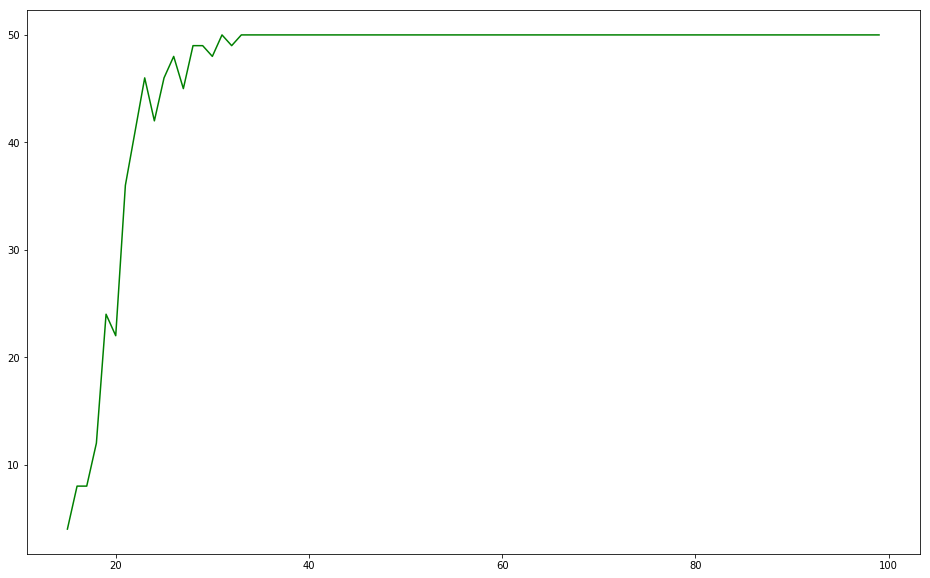

In [27]:
plt.figure(figsize=[16, 10])
plt.plot(df_numwork.index, df_numwork['accuracy'], color='g')
#NOTE: IS SIMULATIONS NOT ACCURACY

- We can see above the minimal number of workers needed for complete the algorithm, Id say 32
- We can also see below the number of workers needed for the best accuracy

In [37]:
accu = df_simulations.groupby('workers').mean()

In [38]:
#df_simulations.groupby('workers').std()

In [41]:
accu.sort_values('accuracy', ascending=False).head(10)['accuracy']

workers
89    0.278200
81    0.277800
16    0.277500
60    0.276800
54    0.276000
68    0.275200
30    0.274583
32    0.274286
61    0.274200
79    0.273800
Name: accuracy, dtype: float64

It doesn't relly look there is a pettern...

---
## Build just one function for simulations

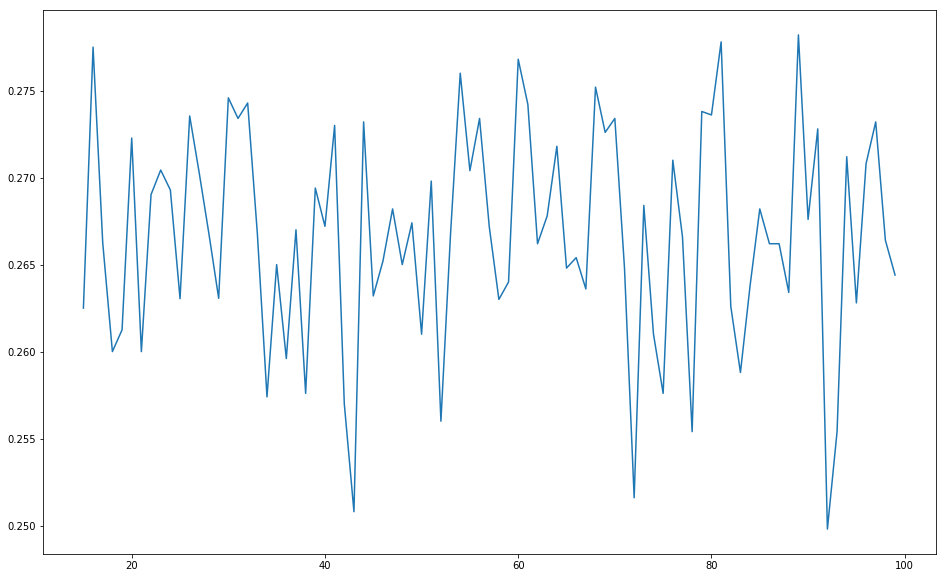

In [42]:
plt.figure(figsize=[16, 10])
#plt.scatter(accu.index, accu['accuracy'])
plt.plot(accu.index, accu['accuracy'])

##### If all our assumptions are correct, this means that oes not really matters how many workers we add to perform certain number of tasks, what it matters is the number of workers per task

### Next steps
- Improving the algorithm
    - Make all the loops and iterations as a functions or whiles, to optimize the computational process
    - Make all this loops one full function
    - Put the algorithm as a package
- Second phase analysis
    - Fixed the number of tasks and workers
    - Evaluate the number of workers per task (default = 7)

At this point we should know what is the range of the optimal number of workers, given 100 tasks. So the next step is making 